In [ ]:
# Retrieve variable df from preparation notebook
%store -r X_train_scaled
%store -r Y_train
%store -r X_val_scaled
%store -r Y_val
%store -r X_test_scaled
%store -r Y_test
%store -r X_test

In [ ]:
print(X_train_scaled.shape)
print(X_val_scaled.shape)

(8190, 51)
(23501, 51)


## Remove failures at time 4

This is required for the time-dependent AUC.

In [ ]:
import numpy as np
import polars as pl

def no_4_data(X: np.ndarray, Y: pl.DataFrame) -> tuple:
    no_4 = pl.concat([pl.from_numpy(X), Y], how="horizontal")
    no_4 = no_4.filter(~((pl.col("distance") == 4) & pl.col("status")))
    X_no_4 = no_4.select(pl.exclude("status", "distance")).to_numpy()
    Y_no_4 = no_4.select("status", "distance").to_numpy(structured=True)
    return X_no_4, Y_no_4


X_train_no_4, Y_train_no_4 = no_4_data(X_train_scaled, Y_train)
X_val_no_4, Y_val_no_4 = no_4_data(X_val_scaled, Y_val)

## Fit models with best hyperparams and score on validation test

In [ ]:
from sksurv.linear_model import CoxnetSurvivalAnalysis, CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest

coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.1, fit_baseline_model=True, alphas = [0.0036247479280241083], alpha_min_ratio=0.01)
coxnet.fit(X_train_no_4, Y_train_no_4)

CoxnetSurvivalAnalysis(alpha_min_ratio=0.01, alphas=[0.0036247479280241083],
                       fit_baseline_model=True, l1_ratio=0.1)

In [ ]:
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train_no_4, Y_train_no_4)

rsf = RandomSurvivalForest(min_samples_split=5, n_estimators=1000, max_depth=None, random_state=2054,  n_jobs = -1)
rsf.fit(X_train_no_4, Y_train_no_4)

RandomSurvivalForest(min_samples_split=5, n_estimators=1000, n_jobs=-1,
                     random_state=2054)

In [ ]:
from sksurv.tree import SurvivalTree

st = SurvivalTree(min_samples_split=5, splitter="best", max_depth=5, random_state=2054)
st.fit(X_train_no_4, Y_train_no_4)

SurvivalTree(max_depth=5, min_samples_split=5, random_state=2054)

Define a function that for every model supplied computes the c-index, the time-dependent AUCs (on the plot) and the mean AUC.

model,c-index,mean AUC
str,f64,f64
"""Cox""",0.7892,0.7896
"""CoxNet""",0.7887,0.7892
"""RandSurvForest…",0.7971,0.8035
"""SurvTree""",0.7383,0.7417
"""random""",0.5,0.5


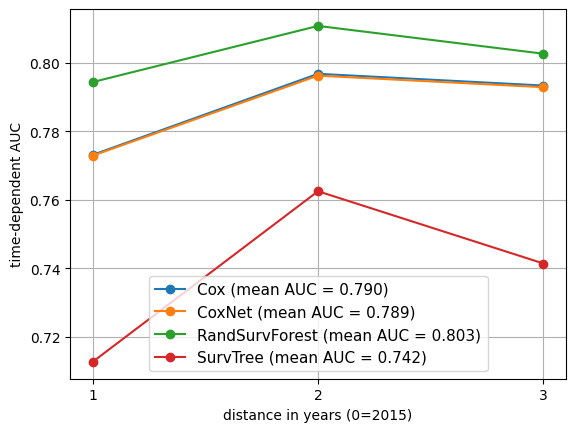

In [ ]:
from sksurv.metrics import cumulative_dynamic_auc
import polars as pl

import numpy as np
import matplotlib.pyplot as plt


def metrics_and_plot(models: list[tuple[str, object]], X_train, Y_train, X_val, Y_val):
    time_periods = range(1, 4) # from 1 to 3 included, because time period 4 contains failures

    scores = [] # c-index
    mean_aucs = [] # mean AUC

    for model_name, model in models:
        if model_name == 'random':
            model_risk_scores = 0.5 * np.ones((Y_val.shape[0], len(time_periods)))
        else:
            # Predict comulative hazard function
            model_chf = model.predict_cumulative_hazard_function(X_val, return_array=False)
            # Get the hazard scores for each time period
            model_risk_scores = np.row_stack([fn(time_periods) for fn in model_chf])
        # Generate a dynamic AUC from the hazard scores at every time period
        model_auc, model_mean_auc = cumulative_dynamic_auc(
            Y_train,
            Y_val,
            model_risk_scores,
            time_periods
        )
        mean_aucs.append(model_mean_auc)
        
        if model_name == "random":
            score = 0.5 # for random model, 0.5 is the c-index, otherwise compute c-index
        else:
            score = model.score(X_val, Y_val)
        
        scores.append(score)
        
        if model_name != "random": # add mean AUC to legend except for random model which would distort the scale
            plt.plot(time_periods, model_auc, "o-", label=f"{model_name} (mean AUC = {model_mean_auc:.3f})")
    plt.xlabel("distance in years (0=2015)")
    plt.xticks([1, 2, 3])
    plt.ylabel("time-dependent AUC")
    plt.legend(loc="lower center", prop={'size': 11})
    plt.grid(True)

    # create table for the results
    table = pl.DataFrame([
        pl.Series('model', [model_name for model_name, _ in models]),
        pl.Series("c-index", scores).round(4),
        pl.Series("mean AUC", mean_aucs).round(4),
    ])
    return table
    

random = 0.5
# assign models, with a model name specified for the plot and table
models = [('Cox', cox), ('CoxNet', coxnet), ('RandSurvForest', rsf), ('SurvTree', st), ('random', random)]

table = metrics_and_plot(models, X_train_no_4, Y_train_no_4, X_val_no_4, Y_val_no_4)
table

## Final score on test set

In [ ]:
from sksurv.ensemble import RandomSurvivalForest

rsf = RandomSurvivalForest(min_samples_split=5, n_estimators=1000, max_depth=None, random_state=2054,  n_jobs = -1)
rsf.fit(X_train_scaled, Y_train.to_numpy(structured=True))
score = rsf.score(X_test_scaled, Y_test.to_numpy(structured=True))
round(score, 4)

0.783

### Permutation importante of the RSF

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test_scaled, Y_test.to_numpy(structured=True), n_repeats=5, random_state=2054, n_jobs=-1)


In [ ]:
import pandas as pd

random = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False, key=abs)
random

,importances_mean,importances_std
Interest/Operating profit % 2015,2.675924e-02,0.001759
Short term debt to equity 2015,1.752002e-02,0.002563
Short term debt to equity 2014,1.261867e-02,0.001836
Leverage 2015,7.451982e-03,0.001244
size=small,6.057145e-03,0.000846
Working cap. turnover (times) 2015,6.046937e-03,0.001594
Stocks/Turnover (days) 2015,5.947608e-03,0.002026
Current ratio 2014,5.525512e-03,0.001763
Current ratio 2015,4.380807e-03,0.001755
Leverage 2014,4.050268e-03,0.001554


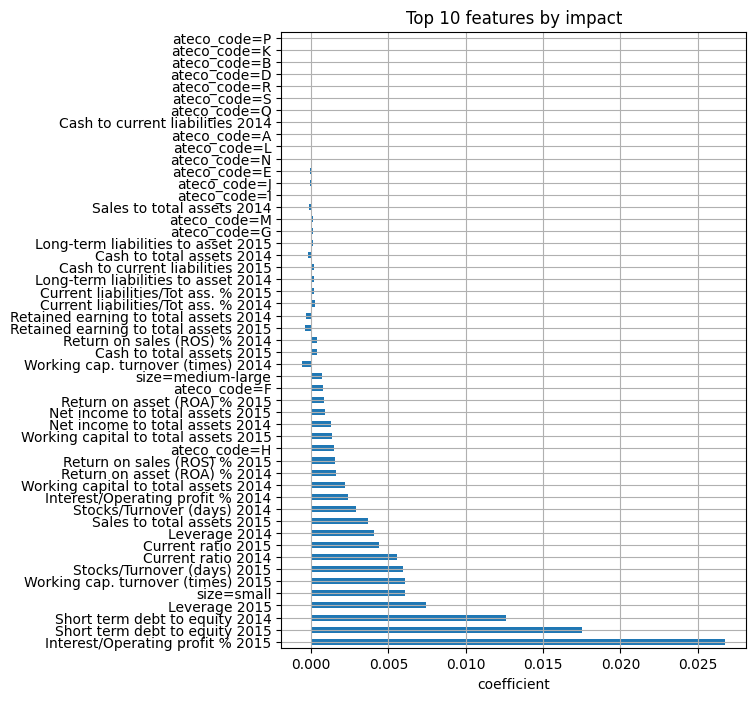

In [ ]:
top_15_coefs = random["importances_mean"] # select the first 15 coefficients for visualization purposes

_, ax = plt.subplots(figsize=(6, 8))
top_15_coefs.plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.set_title("Top 10 features by impact")
ax.grid(True)

plt.show()


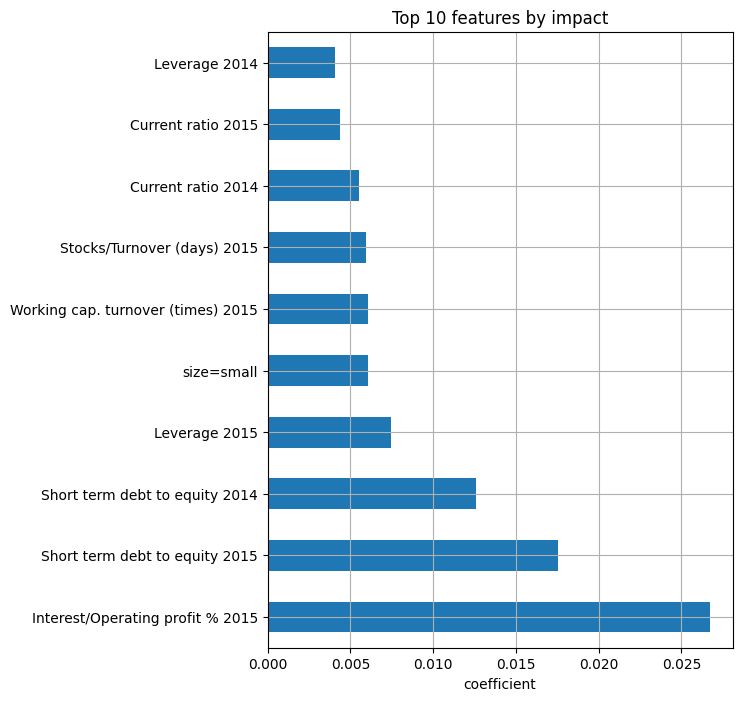

In [ ]:

top_15_coefs = random["importances_mean"][:10] # select the first 15 coefficients for visualization purposes

_, ax = plt.subplots(figsize=(6, 8))
top_15_coefs.plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.set_title("Top 10 features by impact")
ax.grid(True)

plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cda3dc7f-2383-4ca3-97fb-1b86671fd3dc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>